## 加载模型


In [1]:
import os
GPUID='-1'##调用GPU序号
os.environ["CUDA_VISIBLE_DEVICES"] = GPUID
import torch
from apphelper.image import xy_rotate_box,box_rotate,solve
import model


Nms engine gpu_nms: None ,cython_nms: None ,python_nms: <function nms at 0x7fe4b7c5db70>
Text detect engine:keras


In [2]:
import cv2
import numpy as np
def plot_box(img,boxes):
    blue = (0, 0, 0) #18
    tmp = np.copy(img)
    for box in boxes:
         cv2.rectangle(tmp, (int(box[0]),int(box[1])), (int(box[2]), int(box[3])), blue, 1) #19
    
    return Image.fromarray(tmp) 

def plot_boxes(img,angle, result,color=(0,0,0)):
    tmp = np.array(img)
    c = color
    h,w = img.shape[:2]
    thick = int((h + w) / 300)
    i = 0
    if angle in [90,270]:
        imgW,imgH = img.shape[:2]
        
    else:
        imgH,imgW= img.shape[:2]

    for line in result:
        cx =line['cx']
        cy = line['cy']
        degree =line['degree']
        w  = line['w']
        h = line['h']

        x1,y1,x2,y2,x3,y3,x4,y4 = xy_rotate_box(cx, cy, w, h, degree/180*np.pi)
        
        x1,y1,x2,y2,x3,y3,x4,y4 = box_rotate([x1,y1,x2,y2,x3,y3,x4,y4],angle=(360-angle)%360,imgH=imgH,imgW=imgW)
        cx  =np.mean([x1,x2,x3,x4])
        cy  = np.mean([y1,y2,y3,y4])
        cv2.line(tmp,(int(x1),int(y1)),(int(x2),int(y2)),c,1)
        cv2.line(tmp,(int(x2),int(y2)),(int(x3),int(y3)),c,1)
        cv2.line(tmp,(int(x3),int(y3)),(int(x4),int(y4)),c,1)
        cv2.line(tmp,(int(x4),int(y4)),(int(x1),int(y1)),c,1)
        mess=str(i)
        cv2.putText(tmp, mess, (int(cx), int(cy)),0, 1e-3 * h, c, thick // 2)
        i+=1
    return Image.fromarray(tmp).convert('RGB')

It take:5.317052841186523s
既然是自己选的,就不要抱怨,有的时候一条路开始了就不能回
头,也不要回头。不为了别的,只因为既然在开始时你有勇气选
择,就要有本事自己承担起后
[{'cx': 524.5, 'cy': 55.75, 'text': '既然是自己选的,就不要抱怨,有的时候一条路开始了就不能回', 'w': 912.5396101405702, 'h': 36.623103061459034, 'degree': -5.014468398684887}, {'cx': 532.0, 'cy': 117.5, 'text': '头,也不要回头。不为了别的,只因为既然在开始时你有勇气选', 'w': 912.9109477380583, 'h': 37.121422386541155, 'degree': -4.569198188718918}, {'cx': 272.75, 'cy': 197.75, 'text': '择,就要有本事自己承担起后', 'w': 385.03762109285856, 'h': 36.588467570590524, 'degree': -3.4730170535709304}]


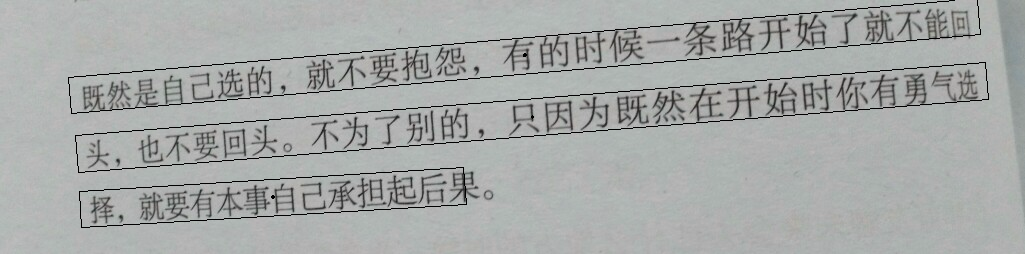

In [3]:
import time
from PIL import Image
p = './test/img.jpeg'
img = cv2.imread(p)

h,w = img.shape[:2]
timeTake = time.time()
_,result,angle= model.model(img,
                                    detectAngle=False,##是否进行文字方向检测
                                    config=dict(MAX_HORIZONTAL_GAP=50,##字符之间的最大间隔，用于文本行的合并
                                    MIN_V_OVERLAPS=0.6,
                                    MIN_SIZE_SIM=0.6,
                                    TEXT_PROPOSALS_MIN_SCORE=0.1,
                                    TEXT_PROPOSALS_NMS_THRESH=0.3,
                                    TEXT_LINE_NMS_THRESH = 0.7,##文本行之间测iou值
                                                                                 
                ),
                                    leftAdjust=True,##对检测的文本行进行向左延伸
                                    rightAdjust=True,##对检测的文本行进行向右延伸
                                    alph=0.01,##对检测的文本行进行向右、左延伸的倍数
                                   
                                   )
        
timeTake = time.time()-timeTake

print('It take:{}s'.format(timeTake))
for line in result:
    print(line['text'])
print(result)
plot_boxes(img,angle, result,color=(0,0,0))

In [4]:
from glob import glob
from PIL import Image
from tqdm import tqdm

CONTRACTS_PATH = '/home/aaron/downloads/租赁合同/瑞思'
CONTRACT_NAME = '亦庄二校租赁合同扫描件'
OCR_RES_PATH = os.path.join(CONTRACTS_PATH, '_'.join([CONTRACT_NAME, 'chineseocr']))
OCR_DETECT_PATH = os.path.join(OCR_RES_PATH, 'detect')
if not os.path.exists(OCR_DETECT_PATH):
    os.makedirs(OCR_DETECT_PATH)

OCR_TEXT_PATH = os.path.join(OCR_RES_PATH, 'text')
if not os.path.exists(OCR_TEXT_PATH):
    os.makedirs(OCR_TEXT_PATH)

ALL_TEXT_TXT = os.path.join(OCR_TEXT_PATH, 'all_text.txt')

FAILED_TXT = os.path.join(OCR_RES_PATH, 'failed.txt')

paths = glob(os.path.join(CONTRACTS_PATH, CONTRACT_NAME, '*.*'))
paths

['/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_1.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_5.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_14.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_4.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_6.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_2.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_10.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_0.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_13.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_3.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_7.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_12.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_8.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_9.png',
 '/home/aaron/downloads/租赁合同/瑞思/亦庄二校租赁合同扫描件/images_11.png']

In [5]:
def ocr(img_file):
    fn_ext = os.path.basename(img_file)
    fn, ext = os.path.splitext(fn_ext)
    _, idx_str = fn.strip().split('_')
    im = Image.open(img_file)
    img = np.array(im.convert('RGB'))


    img = cv2.imread(img_file)

    h,w = img.shape[:2]
#     timeTake = time.time()
    try:
        _,result,angle= model.model(img,
                                            detectAngle=False,##是否进行文字方向检测
                                            config=dict(MAX_HORIZONTAL_GAP=50,##字符之间的最大间隔，用于文本行的合并
                                            MIN_V_OVERLAPS=0.6,
                                            MIN_SIZE_SIM=0.6,
                                            TEXT_PROPOSALS_MIN_SCORE=0.1,
                                            TEXT_PROPOSALS_NMS_THRESH=0.3,
                                            TEXT_LINE_NMS_THRESH = 0.7,##文本行之间测iou值

                        ),
                                            leftAdjust=True,##对检测的文本行进行向左延伸
                                            rightAdjust=True,##对检测的文本行进行向右延伸
                                            alph=0.01,##对检测的文本行进行向右、左延伸的倍数

                                           )

    #     timeTake = time.time()-timeTake
    except:
        print('模型运行失败：{}'.format(img_file))
        return -1, img_file
    
    texts_lists = []
    for line in result:
        texts_lists.append(line['text'])
    texts = '\n'.join(texts_lists)
    text_file = os.path.join(OCR_TEXT_PATH, 'text_page_{}.txt'.format(idx_str))
    with open(text_file, 'w') as f:
        f.write(texts)
        
    detect_img_file = os.path.join(OCR_DETECT_PATH, 'detect_page_{}.jpg'.format(idx_str))
    img_pil = plot_boxes(img,angle, result,color=(0,0,0))
    img_pil.save(detect_img_file)
    return 0, ''

In [6]:
failed_files = []
for img_file in tqdm(paths):
    code, img_file = ocr(img_file)
    if code < 0:
        failed_files.append(img_file)
        
failed_files

100%|██████████| 15/15 [01:31<00:00,  6.31s/it]


[]

In [7]:
if failed_files:
    with open(FAILED_TXT, 'w') as f:
        f.write('\n'.join(failed_files))

In [8]:
with open(ALL_TEXT_TXT, 'a') as f:
    for idx in tqdm(range(len(paths))):
        try:
            text_file = os.path.join(OCR_TEXT_PATH, 'text_page_{}.txt'.format(idx))
            with open(text_file, 'r') as rf:
                text = rf.read()
        except:
            text = '\n'

        f.write('page_{}:\n\n'.format(idx) + text + '\n\n')

100%|██████████| 15/15 [00:00<00:00, 9124.66it/s]
